In [1]:
import numpy as np

import filtering.cardiac_region as cr
import auxiliary.values as v
from auxiliary.data import imaging

In [2]:
line_path = v.data_path + 'Gr1/Segmentation/LinesTissue/line_20190521_E2.nii.gz'
img_path = v.data_path + 'Gr1/Segmentation/Membrane/20190521_E2_mGFP_XYZ_predictions_GASP.nii.gz'

Cropping the image

In [3]:
# margins = cr.get_margins(line_path, img_path)
# cut = cr.crop_img(img_path, margins)

In [5]:
lines = imaging.read_nii(line_path, verbose=1)
img = imaging.read_nii(img_path, verbose=1)
# zeros = np.zeros(img.shape)

Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/Segmentation/LinesTissue/line_20190521_E2.nii.gz
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/Segmentation/Membrane/20190521_E2_mGFP_XYZ_predictions_GASP.nii.gz


In [11]:
# zeros[
#     margins[0][0] : margins[1][0],
#     margins[0][1] : margins[1][1],
#     margins[0][2] : margins[1][2]
# ] = cut

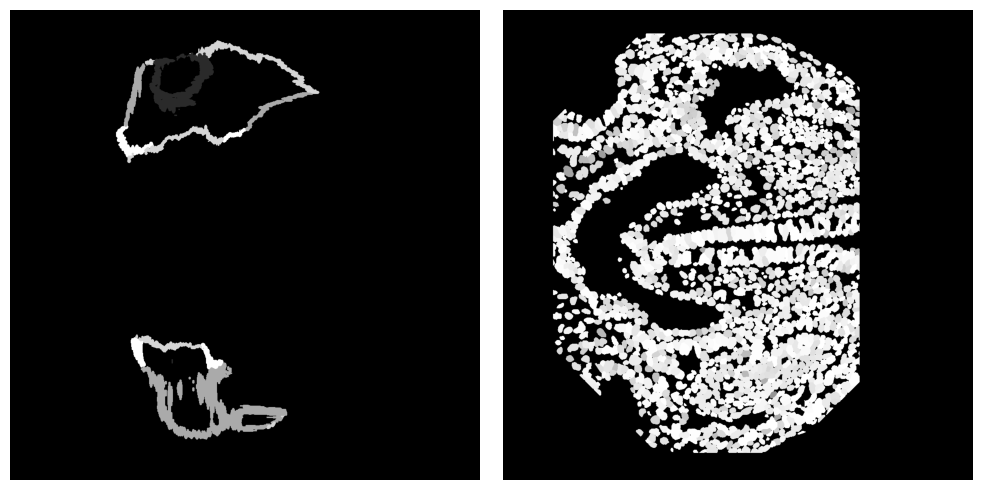

In [24]:
# import matplotlib.pyplot as plt
#
# plt.figure(figsize=(10, 5))
# plt.subplot(121); plt.imshow(lines[..., 180], cmap='gray'); plt.axis('off')
# plt.subplot(122); plt.imshow(zeros[..., 180], cmap='gray'); plt.axis('off')
# plt.tight_layout()
# plt.show()

Filtering by tissue

In [6]:
def filter_by_tissue(img, lines, tissue_name='myocardium', dilate=1, dilate_size=3, verbose=1):
    from auxiliary.utils.colors import bcolors as c
    from auxiliary.utils.timer import LoadingBar
    import sys

    if verbose:
        print(f'{c.OKBLUE}Filtering image by tissue{c.ENDC}: {tissue_name}...')

    try:
        tissue = v.lines[tissue_name]
        if img.ndim == 4:
            img = img[..., 0]
        filtered = np.zeros_like(img)

        if dilate and dilate_size:
            if verbose:
                print(f'{c.BOLD}Dilating mask{c.ENDC}: {dilate} times...')

            ds = dilate_size if dilate_size % 2 else dilate_size + 1
            kernel = np.ones((ds, ds), np.uint8)
            lines = cv2.dilate(lines, kernel, iterations=dilate)

        bar = LoadingBar(lines.shape[-1])

        cell_ids = np.unique(img[lines == tissue])
        # mask = np.isin(img, cell_ids)
        print(np.unique(cell_ids))

        for z in range(lines.shape[-1]):
            if verbose:
                bar.update()
                
            mask = np.isin(img[..., z], cell_ids)
            filtered[..., z] = np.where(mask, img[..., z], 0)

            # cell_ids = np.unique(img[..., z][lines[..., z] == tissue])
            # mask = np.isin(img[..., z], cell_ids)
            # filtered[..., z] = np.where(mask, img[..., z], 0)

    except KeyError:
        print(f'{c.FAIL}Invalid tissue{c.ENDC}: {tissue_name}')
        print(f'{c.BOLD}Available tissues{c.ENDC}: {list(v.lines.keys())}')
        sys.exit(2)

    return filtered

In [7]:
import cv2

# line_path = v.data_path + 'Gr1/Segmentation/LinesTissue/line_20190521_E2.nii.gz'
# img_path = v.data_path + 'Gr1/Segmentation/Nuclei/20190521_E2_Fernando.tif'
#
# img = imaging.read_tiff(img_path, verbose=1)
# lines = imaging.read_nii(line_path, verbose=1)

filtered_img = filter_by_tissue(
    img, lines, tissue_name='myocardium',
    dilate=1, dilate_size=3,
    verbose=1
)

Filtering image by tissue: myocardium...
Dilating mask: 1 times...
[   0.   56.   76. ... 4899. 4902. 5160.]
[==================================================] 100.00%

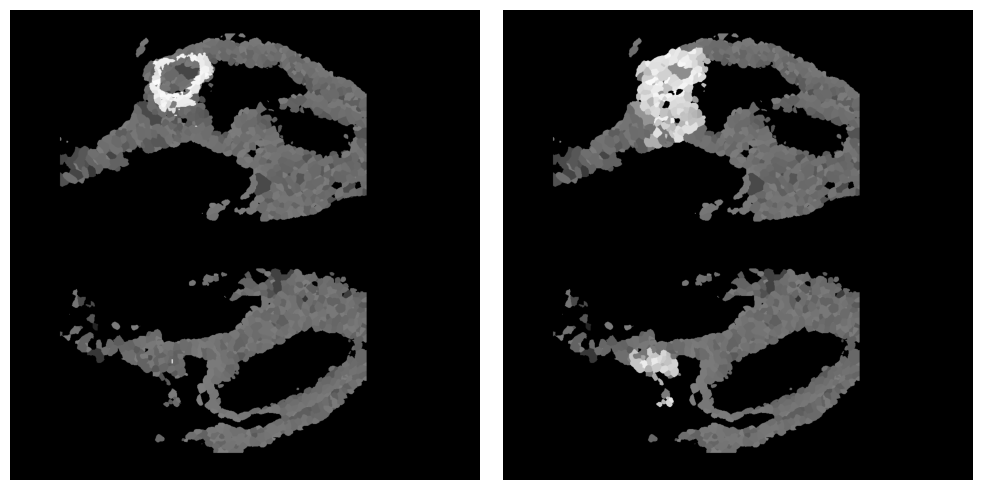

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

myocardium = np.isin(lines, v.lines['myocardium'])

plt.subplot(121); plt.imshow(img[..., 180], cmap='gray'); plt.axis('off')
plt.imshow(myocardium[..., 180], cmap='gray', alpha=.5)

plt.subplot(122); plt.imshow(img[..., 180], cmap='gray'); plt.axis('off')
plt.imshow(filtered_img[..., 180], cmap='gray', alpha=.5)
plt.tight_layout()
plt.show()

In [9]:
imaging.save_prediction(
    filtered_img, '../filtering/filtered_example_dilate_1.3.tif', 
    verbose=1
)

/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/csbdeep/io/__init__.py:43: UserWarning: Converting data type from 'float64' to ImageJ-compatible 'float32'.
  warnings.warn("Converting data type from '%s' to ImageJ-compatible '%s'." % (t, np.dtype(t_new)))



Saving prediction: ../filtering/filtered_example_dilate_1.3.tif
